In [2]:
import pandas
import geopandas
from shapely.geometry import Point


In [11]:
site_data = pandas.DataFrame(pandas.read_excel('../test_data/NTGS_data/Henbury/HenburyStructure.xlsx'))

In [12]:
s1_data = pandas.DataFrame()
s1_data['X'] = site_data.loc[(site_data['Dip_S1'] != -9) & (site_data['Azimuth_S1'] != -9), 'X_Easting']
s1_data['Y'] = site_data.loc[(site_data['Dip_S1'] != -9) & (site_data['Azimuth_S1'] != -9), 'Y_Northing']
s1_data['Z'] = 0
s1_data['DIP'] = site_data.loc[(site_data['Dip_S1'] != -9) & (site_data['Azimuth_S1'] != -9), 'Dip_S1']
s1_data['dipdir'] = site_data.loc[(site_data['Dip_S1'] != -9) & (site_data['Azimuth_S1'] != -9), 'Azimuth_S1']
s1_data['feature_name'] = 's1' 

s0_data = pandas.DataFrame()
s0_data['X'] = site_data.loc[(site_data['Dip_S0'] != -9) & (site_data['Azimuth_S0'] != -9), 'X_Easting']
s0_data['Y'] = site_data.loc[(site_data['Dip_S0'] != -9) & (site_data['Azimuth_S0'] != -9), 'Y_Northing']
s0_data['Z'] = 0
s0_data['dip'] = site_data.loc[(site_data['Dip_S0'] != -9) & (site_data['Azimuth_S0'] != -9), 'Dip_S0']
s0_data['dipdir'] = site_data.loc[(site_data['Dip_S0'] != -9) & (site_data['Azimuth_S0'] != -9), 'Azimuth_S0']
s0_data['feature_name'] = 's0'

data = pandas.concat([s1_data, s0_data], ignore_index=True)
data.to_csv('site_data_processed.csv', index=False)


In [6]:
# Create a geometry column from the X and Y coordinates
geometry = [Point(xy) for xy in zip(data['X'], data['Y'])]

# Create a GeoDataFrame
geo_data = geopandas.GeoDataFrame(data, geometry=geometry)

geo_data.crs = {'init': 'EPSG:28353'}

/home/rabii/Git_Repos/m2l_pypi/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [7]:
geo_data.to_file('../test_data/NTGS_data/Henbury/site_HenburyStructure.shp')

/tmp/ipykernel_28387/2161381574.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  geo_data.to_file('../test_data/NTGS_data/Henbury/site_HenburyStructure.shp')
/home/rabii/Git_Repos/m2l_pypi/lib/python3.11/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'feature_name' to 'feature_na'
  ogr_write(


In [32]:
import argparse
import time
import numpy as np
import jax
from jax import vmap
import jax.numpy as jnp
import jax.random as random
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, init_to_value

import matplotlib.pyplot as plt


# Define the periodic kernel
def periodic_kernel(X, Z, var, length, period, noise, jitter=1.0e-6, include_noise=True):
    dists = jnp.abs(X[:, None] - Z)
    periodic_part = jnp.sin(jnp.pi * dists / period) ** 2
    k = var * jnp.exp(-2 * periodic_part / length ** 2)
    if include_noise:
        k += (noise + jitter) * jnp.eye(X.shape[0])
    return k


# Define the Gaussian Process model
def model(X, Y):
    var = numpyro.sample("kernel_var", dist.LogNormal(0.0, 10.0))
    noise = numpyro.sample("kernel_noise", dist.LogNormal(0.0, 10.0))
    length = numpyro.sample("kernel_length", dist.LogNormal(0.0, 10.0))
    period = numpyro.sample("kernel_period", dist.Uniform(0.1, 5.0))

    k = periodic_kernel(X, X, var, length, period, noise)
    numpyro.sample(
        "Y",
        dist.MultivariateNormal(loc=jnp.zeros(X.shape[0]), covariance_matrix=k),
        obs=Y,
    )


# Generate synthetic data
def get_data(N=30, sigma_obs=0.2, N_test=400):
    np.random.seed(0)
    X = jnp.linspace(0, 10, N)
    Y = jnp.sin(2 * jnp.pi * X / 3) + sigma_obs * np.random.randn(N)

    assert X.shape == (N,)
    assert Y.shape == (N,)

    X_test = jnp.linspace(-1, 11, N_test)
    return X, Y, X_test


# Perform inference
def run_inference(model, X, Y, num_warmup=1000, num_samples=1000, num_chains=1):
    init_strategy = init_to_value(
        values={"kernel_var": 1.0, "kernel_noise": 0.2, "kernel_length": 0.5, "kernel_period": 3.0}
    )
    kernel = NUTS(model, init_strategy=init_strategy)
    mcmc = MCMC(kernel, num_warmup=num_warmup, num_samples=num_samples, num_chains=num_chains)
    mcmc.run(random.PRNGKey(0), X, Y)
    mcmc.print_summary()
    return mcmc.get_samples()


# Make predictions
def predict_periodic(rng_key, X, Y, X_test, var, length, period, noise, use_cholesky=True):
    k_pp = periodic_kernel(X_test, X_test, var, length, period, noise, include_noise=True)
    k_pX = periodic_kernel(X_test, X, var, length, period, noise, include_noise=False)
    k_XX = periodic_kernel(X, X, var, length, period, noise, include_noise=True)

    if use_cholesky:
        K_xx_cho = jax.scipy.linalg.cho_factor(k_XX)
        K = k_pp - jnp.matmul(k_pX, jax.scipy.linalg.cho_solve(K_xx_cho, k_pX.T))
        mean = jnp.matmul(k_pX, jax.scipy.linalg.cho_solve(K_xx_cho, Y))
    else:
        K_xx_inv = jnp.linalg.inv(k_XX)
        K = k_pp - jnp.matmul(k_pX, jnp.matmul(K_xx_inv, jnp.transpose(k_pX)))
        mean = jnp.matmul(k_pX, jnp.matmul(K_xx_inv, Y))

    sigma_noise = jnp.sqrt(jnp.clip(jnp.diag(K), 0.0)) * jax.random.normal(
        rng_key, X_test.shape[:1]
    )

    return mean, mean + sigma_noise


# Main function
def main():
    # Generate data
    X, Y, X_test = get_data()

    # Perform inference
    samples = run_inference(model, X, Y)

    # Predict using the periodic kernel
    vmap_args = (
        random.split(random.PRNGKey(1), samples["kernel_var"].shape[0]),
        samples["kernel_var"],
        samples["kernel_length"],
        samples["kernel_period"],
        samples["kernel_noise"],
    )
    means, predictions = vmap(
        lambda rng_key, var, length, period, noise: predict_periodic(
            rng_key, X, Y, X_test, var, length, period, noise, use_cholesky=True
        )
    )(*vmap_args)

    mean_prediction = np.mean(means, axis=0)
    percentiles = np.percentile(predictions, [5.0, 95.0], axis=0)

    return X, Y, X_test, mean_prediction, percentiles


if __name__ == "__main__":
    X, Y, X_test, mean_prediction, percentiles = main()
    


  0%|          | 0/2000 [00:00<?, ?it/s]

sample: 100%|██████████| 2000/2000 [00:03<00:00, 543.76it/s, 11 steps of size 1.75e-01. acc. prob=0.95]



                     mean       std    median      5.0%     95.0%     n_eff     r_hat
  kernel_length     10.91     25.31      4.43      0.49     20.51    311.12      1.00
   kernel_noise      0.06      0.02      0.05      0.03      0.08    412.72      1.00
  kernel_period      3.02      0.03      3.02      2.97      3.06    498.69      1.00
     kernel_var    351.51   2454.06      7.09      0.17    203.88    377.85      1.00

Number of divergences: 2


Text(0.5, 1.0, 'Gaussian Process Regression with Periodic Kernel')

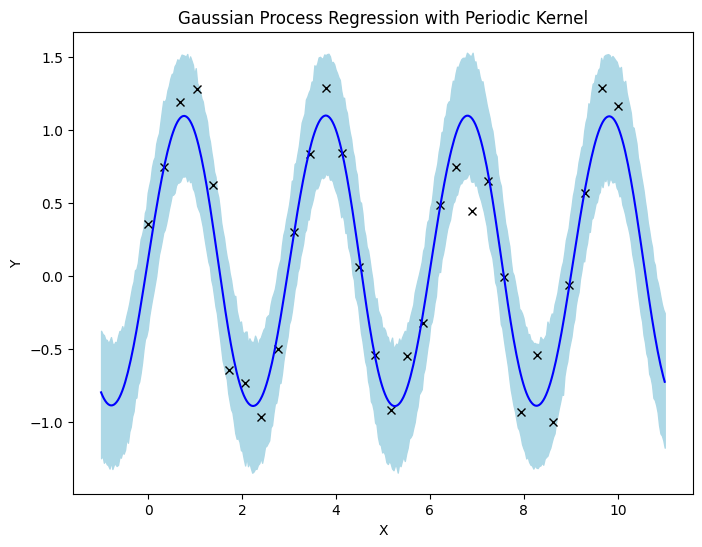

In [33]:
# Plot results
plt.figure(figsize=(8, 6))
plt.plot(X, Y, "kx", label="Observed Data")
plt.fill_between(X_test, percentiles[0, :], percentiles[1, :], color="lightblue", label="90% CI")
plt.plot(X_test, mean_prediction, "blue", label="Mean Prediction")
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Gaussian Process Regression with Periodic Kernel")
# plt.legend()
# plt.show()

# plt.savefig("gp_periodic_kernel.png")

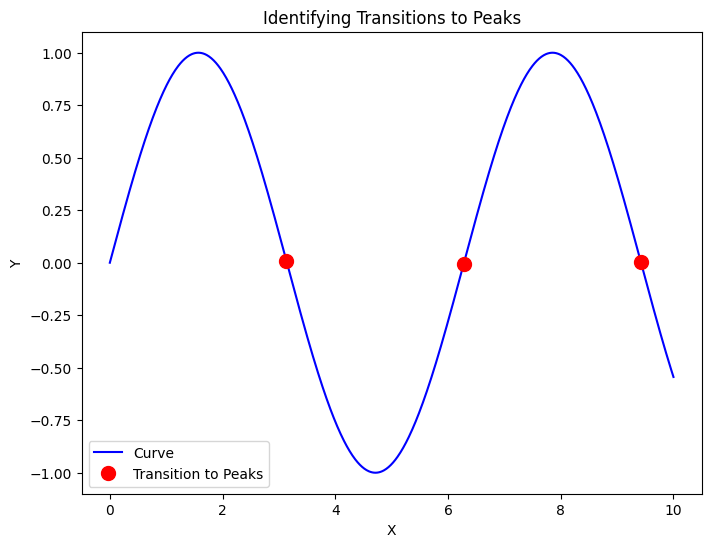

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Simulate periodic data (replace with your actual data)
x = np.linspace(0, 10, 1000)
y = np.sin(x)

# Compute the first and second derivatives
dy_dx = np.gradient(y, x)  # First derivative
d2y_dx2 = np.gradient(dy_dx, x)  # Second derivative

# Find zero-crossings of the second derivative (inflection points)
inflection_points = np.where(np.diff(np.sign(d2y_dx2)))[0]

# Plot the curve and mark the transition points
plt.figure(figsize=(8, 6))
plt.plot(x, y, label='Curve', color='blue')
plt.plot(x[inflection_points], y[inflection_points], 'o', markersize=10, label='Transition to Peaks', color='red')
plt.title("Identifying Transitions to Peaks")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.show()


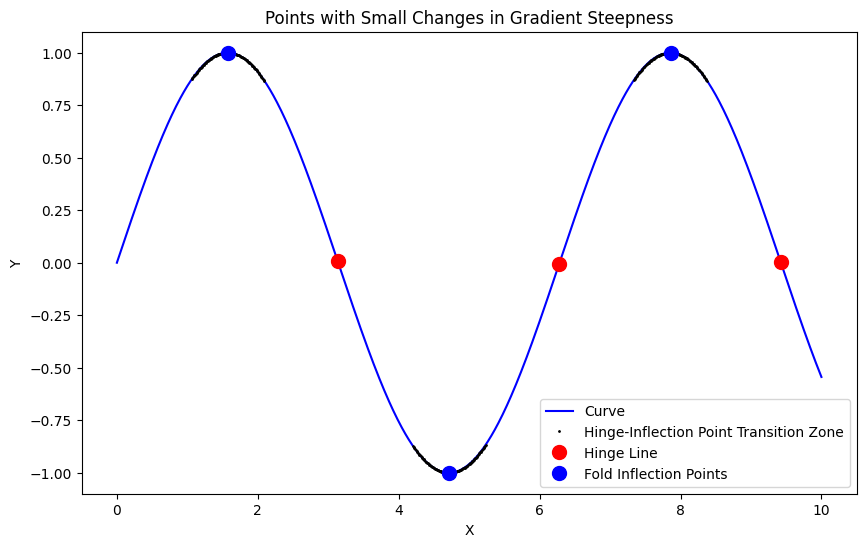

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
# Simulate periodic data (replace with your actual data)
x = np.linspace(0, 10, 1000)
y = np.sin(x)

peaks, _ = find_peaks(abs(y))
# Compute the first and second derivatives
dy_dx = np.gradient(y, x)       # First derivative (gradient)
d2y_dx2 = np.gradient(dy_dx, x)  # Second derivative (rate of change of gradient)

# Set a threshold for detecting small changes in steepness
threshold = 0.005  # Tweak this value as needed

# Find points with small changes in the second derivative
smooth_transition_points = []
for i in range(1, len(d2y_dx2) - 1):
    # Check for small changes in the second derivative
    if abs(d2y_dx2[i] - d2y_dx2[i - 1]) <= threshold:
        smooth_transition_points.append(i)
inflection_points = np.where(np.diff(np.sign(d2y_dx2)))[0]
# Plot the curve and mark the smooth transition points
plt.figure(figsize=(10, 6))
plt.plot(x, y, label='Curve', color='blue')
plt.plot(x[smooth_transition_points], y[smooth_transition_points], 'o', markersize=1, label='Hinge-Inflection Point Transition Zone', color='black')
plt.plot(x[inflection_points], y[inflection_points], 'o', markersize=10, label='Hinge Line', color='red')
plt.plot(x[peaks], y[peaks], 'o', markersize=10, label='Fold Inflection Points', color='blue')
plt.title("Points with Small Changes in Gradient Steepness")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.show()
